In [16]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Set up paths

path_to_data = '/expanse/nfs/cw3e/cwp140/'     # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [5]:
fname = os.path.join(path_to_data, 'preprocessed/SEAK-WRF-PCPT/PCPT_quantiles.nc')
ds = xr.open_dataset(fname)
ds = ds.sel(quantile=0.9)
ds

<xarray.Dataset>
Dimensions:   (y: 250, x: 320)
Coordinates:
    lat       (y, x) float32 ...
    lon       (y, x) float32 ...
    quantile  float64 0.9
Dimensions without coordinates: y, x
Data variables:
    PCPT      (y, x) float64 ...

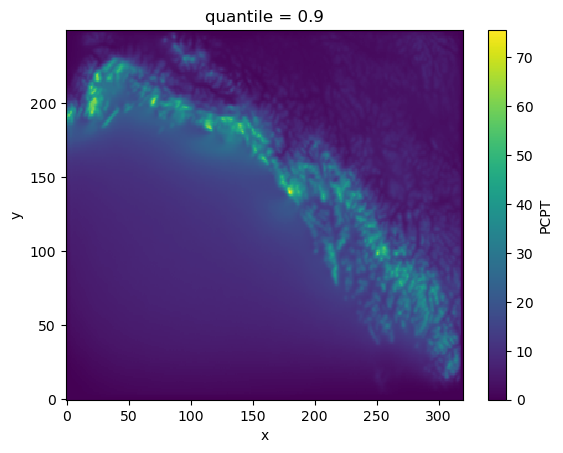

In [8]:
ds.PCPT.plot()

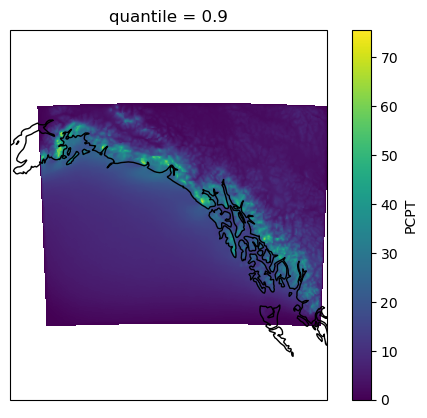

In [23]:
mapcrs = ccrs.LambertConformal(central_longitude=-138.5, central_latitude=58.0)
datacrs = ccrs.PlateCarree()

p = ds.PCPT.plot(x='lon', y='lat',
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},
)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-150, -129, 50, 65])

In [6]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
varname = 'PCPT' # 'PCPT' or 'UV'

fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format(varname)
wrf = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')
if temporal_res == 'hourly':
    wrf = wrf
elif (temporal_res == 'daily') & (varname == 'PCPT'):
    wrf = wrf.resample(time="1D").sum('time') # resample WRF data to be mm per day
    
elif (temporal_res == 'daily') & (varname == 'UV'):
    wrf = wrf.sel(lev='1000')
    wrf = wrf.resample(time="1D").mean('time') # resample WRF data to be m s-1

wrf

<xarray.Dataset>
Dimensions:  (time: 14610, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    PCPT     (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Sat Dec  8 15:40:16 AKST 2018

In [11]:
## use where statement to get dates where precip > 90th percentile
tmp = wrf.where(wrf.PCPT >= ds.PCPT)
tmp

<xarray.Dataset>
Dimensions:   (time: 14610, y: 250, x: 320)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat       (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon       (y, x) float32 -148.1 -148.0 -147.9 ... -126.4 -126.3 -126.3
    quantile  float64 0.9
Dimensions without coordinates: y, x
Data variables:
    PCPT      (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Sat Dec  8 15:40:16 AKST 2018

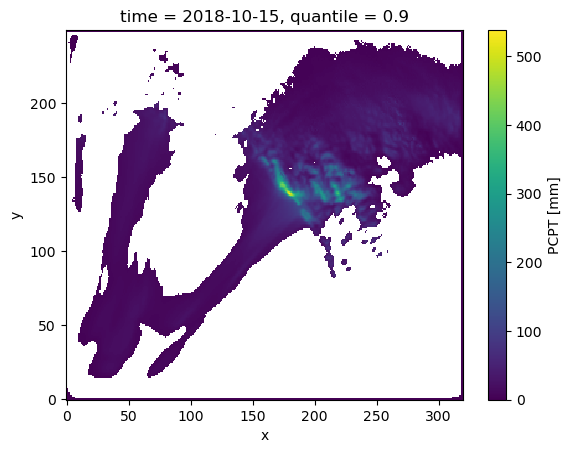

In [25]:
tmp.sel(time='2018-10-15').PCPT.plot()

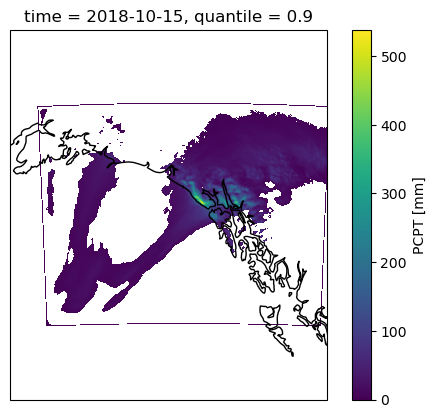

In [26]:
mapcrs = ccrs.LambertConformal(central_longitude=-138.5, central_latitude=58.0)
datacrs = ccrs.PlateCarree()

p = tmp.sel(time='2018-10-15').PCPT.plot(x='lon', y='lat',
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},
)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-150, -129, 50, 65])